In [138]:
# basic imports
import numpy as np
import pandas as pd
from time import time
from sklearn.decomposition import PCA

# demos for visualization
from nilearn import datasets
from nilearn import plotting
from nilearn.connectome import GroupSparseCovariance
from nilearn.connectome import ConnectivityMeasure

import matplotlib.pyplot as plt

# for ML
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import TensorDataset, DataLoader

# os library
from os.path import exists, join

In [2]:
data_path = join(".", "data") if exists(join(".", "data")) \
    else join("..", "input", "statistical-learning-sapienza-spring-2021")

In [3]:
train = pd.read_csv(join(data_path, 'train.csv'))

In [4]:
def get_data(entry):
    id = entry.id
    variables = entry[['var1', 'var2', 'var3']].to_numpy()
    timeseries = entry[5 if "y" in entry.index else 4:].to_numpy(dtype=float).reshape((115, 116), order="F")
    if "y" in entry.index: return id, entry.y, variables, timeseries
    else: return id, variables, timeseries

In [5]:
train_split, val_split = train_test_split(train, test_size=0.2, random_state=42)

In [170]:
def get_dataloader(timeseries, labels):
    return DataLoader(TensorDataset(torch.Tensor(timeseries),torch.Tensor(labels)), batch_size=10) # create your dataloader

train_timeseries = train_split.apply(lambda row: get_data(row)[-1], axis=1).to_list()
train_dataloader = get_dataloader(train_timeseries, train_split.y.to_list())
val_timeseries = val_split.apply(lambda row: get_data(row)[-1], axis=1).to_list()
val_dataloader = get_dataloader(val_timeseries, val_split.y.to_list())

## Model

In [171]:
class BlackEmbedding(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.rnn_model = nn.RNN(input_size=116, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size*(1+num_layers), 32)
        self.regressor = nn.Linear(32, 1)

    def forward(self, x, predict_anyway=False):

        x, h = self.rnn_model(x)

        h = torch.cat(list(map(lambda i: h[i, ], range(h.shape[0]))), dim=-1)

        x = torch.cat([x[:, -1, ], h], dim=-1)  # taking only the last

        x = F.relu(self.fc1(x))

        if self.training or predict_anyway:
            x = self.regressor(x)

        return x

model = BlackEmbedding(hidden_size=64, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

## Training

In [172]:
epocs = 30
rmse = {"train": [], "val": []}

start = time()
for epoch in range(epocs):
    model.train()
    rmse["train"].append(0)
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(inputs)

        # forward + backward + optimize
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        rmse["train"][epoch] += loss.sqrt().mean(dim=0)/len(train_dataloader)

    # validation
    model.eval()

    rmse["val"].append(0)
    for i, data in enumerate(val_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        with torch.no_grad():
            outputs = model(inputs, predict_anyway=True)

        # forward + backward + optimize
        rmse["val"][epoch] += criterion(outputs, labels).sqrt().mean(dim=0)/len(val_dataloader)
    print(f"\n------> Epoch {epoch+1} <------\n    Train RMSE loss: {rmse['train'][epoch]}\n    Val   RMSE loss: {rmse['val'][epoch]}")

print('\n\n****************** Finished Training ******************')
print("seconds elapsed: ", time()-start)

C:\ProgramData\Anaconda3\envs\SLHaka\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



------> Epoch 1 <------
    Train RMSE loss: 109.96170043945312
    Val   RMSE loss: 108.21951293945312

------> Epoch 2 <------
    Train RMSE loss: 109.28860473632812
    Val   RMSE loss: 107.01258087158203

------> Epoch 3 <------
    Train RMSE loss: 107.47926330566406
    Val   RMSE loss: 104.6358642578125

------> Epoch 4 <------
    Train RMSE loss: 104.49647521972656
    Val   RMSE loss: 101.17689514160156

------> Epoch 5 <------
    Train RMSE loss: 100.81016540527344
    Val   RMSE loss: 97.32369995117188

------> Epoch 6 <------
    Train RMSE loss: 96.81134796142578
    Val   RMSE loss: 93.18553161621094

------> Epoch 7 <------
    Train RMSE loss: 92.53305053710938
    Val   RMSE loss: 88.68888092041016

------> Epoch 8 <------
    Train RMSE loss: 88.01128387451172
    Val   RMSE loss: 84.05693817138672

------> Epoch 9 <------
    Train RMSE loss: 83.49514770507812
    Val   RMSE loss: 79.33466339111328

------> Epoch 10 <------
    Train RMSE loss: 78.960693359375
  

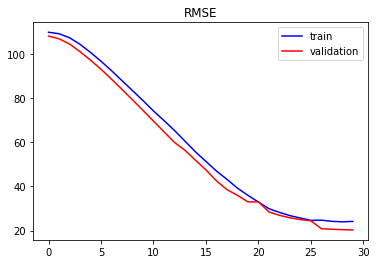

In [173]:
plt.plot(range(len(rmse["train"])), rmse["train"], color="blue", label="train")
plt.plot(range(len(rmse["val"])), rmse["val"], color="red", label="validation")
plt.title("RMSE")
plt.legend()
plt.show()

In [174]:
train_embedding = model.forward(torch.Tensor(train_timeseries))
val_embedding = model.forward(torch.Tensor(val_timeseries))

In [175]:
train_embedding_df = pd.concat([train_split.iloc[:, 2:4], pd.DataFrame(train_embedding.detach().numpy(), index=train_split.index)], axis=1)
val_embedding_df = pd.concat([val_split.iloc[:, 2:4], pd.DataFrame(val_embedding.detach().numpy(), index=val_split.index)], axis=1)

In [176]:
train_embedding_df.var2 = train_embedding_df.var2.replace({"A": 0, "C": 1})
val_embedding_df.var2 = val_embedding_df.var2.replace({"A": 0, "C": 1})

In [177]:
X_train, X_val = train_embedding_df.to_numpy(), val_embedding_df.to_numpy()
y_train, y_val = train_split.y.to_numpy(), val_split.y.to_numpy()

In [178]:
svm_model = svm.SVR(shrinking=True, kernel="sigmoid", gamma="scale", degree=4, C=0.5)

svm_model.fit(X_train, y_train)

SVR(C=0.5, degree=4, kernel='sigmoid')

In [179]:
y_ped_train = svm_model.predict(X_train)
y_ped_val = svm_model.predict(X_val)

In [180]:
print(f"train : {np.sqrt(mean_squared_error(y_ped_train, y_train))} \nval  : {np.sqrt(mean_squared_error(y_ped_val, y_val))}")

train : 14.46731332919218 
val  : 16.120551887566872


In [181]:
pd.DataFrame(val_embedding.detach().numpy(), index=val_split.index)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
110,0.000000,0.0,33.637390,0.000000,33.896420,0.0,30.615675,31.881088,31.626308,0.0,...,28.560516,0.0000,33.136833,0.0,30.388554,31.317009,30.641258,29.553339,0.0,0.000000
419,0.000000,0.0,33.666306,0.000000,33.922497,0.0,30.645451,31.905592,31.652485,0.0,...,28.585737,0.0000,33.165642,0.0,30.417480,31.347656,30.668304,29.575769,0.0,0.000000
565,0.000000,0.0,33.663048,0.000000,33.919193,0.0,30.641996,31.902082,31.648861,0.0,...,28.582979,0.0000,33.162563,0.0,30.414177,31.344082,30.664511,29.572756,0.0,0.000000
77,0.000000,0.0,25.453283,0.000000,26.474634,0.0,23.194553,24.252129,24.933500,0.0,...,21.665619,0.2713,25.743305,0.0,22.891548,24.141226,23.771708,22.632118,0.0,0.032363
181,0.000000,0.0,33.622978,0.000000,33.884037,0.0,30.611977,31.857613,31.602100,0.0,...,28.555353,0.0000,33.120586,0.0,30.365826,31.302959,30.623489,29.535894,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.000000,0.0,33.666332,0.000000,33.922523,0.0,30.645472,31.905622,31.652496,0.0,...,28.585690,0.0000,33.165638,0.0,30.417484,31.347687,30.668293,29.575781,0.0,0.000000
340,0.000000,0.0,33.666298,0.000000,33.922527,0.0,30.645456,31.905621,31.652515,0.0,...,28.585758,0.0000,33.165642,0.0,30.417496,31.347713,30.668343,29.575809,0.0,0.000000
148,0.042667,0.0,32.572865,0.100658,32.659508,0.0,29.666977,30.599995,30.702549,0.0,...,27.752827,0.0000,32.023682,0.0,29.502060,30.236879,29.531418,28.562664,0.0,0.000000
494,0.000000,0.0,33.655487,0.000000,33.915691,0.0,30.638044,31.897831,31.643623,0.0,...,28.577787,0.0000,33.156681,0.0,30.407158,31.340368,30.659786,29.570171,0.0,0.000000


In [182]:
test = pd.read_csv(join(data_path, 'test.csv'))
time_series_test = test.apply(lambda row: get_data(row)[-1], axis=1).to_list()

In [183]:
predictions = model.forward(torch.Tensor(time_series_test), predict_anyway=True)

In [62]:
test_embedding_df = pd.concat([test.iloc[:, 2:4], pd.DataFrame(test_embedding.detach().numpy(), index=test.index)], axis=1)

In [133]:
val_pred

tensor([[106.7174],
        [106.8461],
        [106.8462],
        [ 40.6383],
        [106.8414],
        [106.8447],
        [106.8461],
        [ 97.3616],
        [ 35.5079],
        [106.8461],
        [ 93.9863],
        [106.8318],
        [-39.6860],
        [106.8460],
        [106.8461],
        [106.8429],
        [106.8459],
        [106.8445],
        [106.8419],
        [-19.4348],
        [106.8454],
        [106.8446],
        [106.8400],
        [106.8461],
        [106.8461],
        [106.8448],
        [-38.0568],
        [106.6906],
        [106.8460],
        [106.8461],
        [106.8459],
        [ 97.5422],
        [ 21.0665],
        [106.8434],
        [106.8444],
        [106.8461],
        [101.3131],
        [106.8457],
        [106.8461],
        [106.8458],
        [106.8461],
        [106.8453],
        [106.8457],
        [106.8460],
        [106.8461],
        [106.8441],
        [ 14.8656],
        [106.3747],
        [ 20.8572],
        [106.8396],


In [67]:
y_ped_val = model.forward(torch.Tensor(val_timeseries), predict_anyway=True)